**1. Regression by Successive Orthogonalization**

    Step                 Feature  Coefficient
0      1             Distance_km    17.170536
1      2    Preparation_Time_min     6.796038
2      3  Courier_Experience_yrs    -1.844353
3      4           Weather_Foggy     1.416133
4      5           Weather_Rainy     1.529439
5      6           Weather_Snowy     2.626559
6      7           Weather_Windy     0.920198
7      8       Traffic_Level_Low    -3.745227
8      9    Traffic_Level_Medium    -3.447435
9     10     Time_of_Day_Evening     0.566928
10    11     Time_of_Day_Morning     0.240932
11    12       Time_of_Day_Night    -0.054758
12    13        Vehicle_Type_Car     0.282414
13    14    Vehicle_Type_Scooter    -0.515927
    Step       RMSE
0      1  12.593925
1      2  10.288618
2      3  10.254642
3      4  10.156411
4      5  10.139220
5      6   9.844894
6      7   9.823734
7      8   9.106369
8      9   9.044889
9     10   9.049416
10    11   9.063423
11    12   9.061323
12    13   9.052119
13    14   9.058463


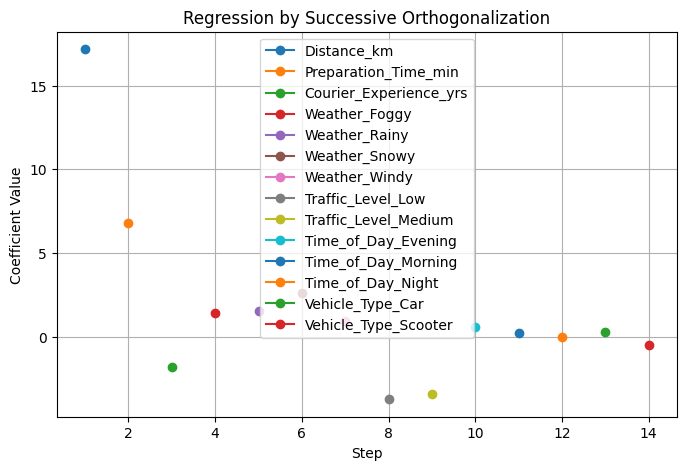

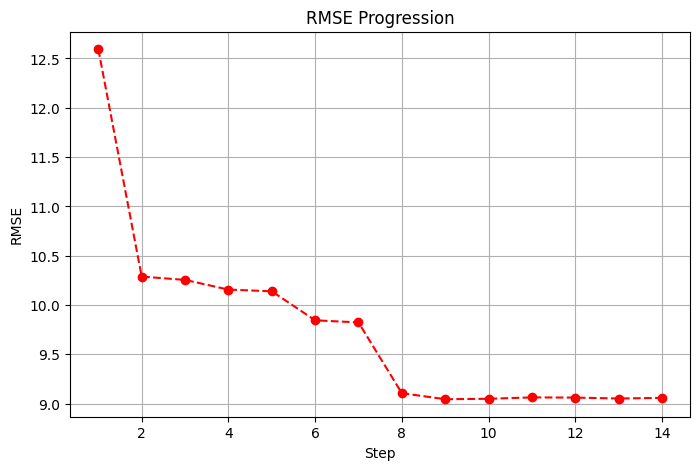

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Load the uploaded CSV files
train_file_path = "deliverytimeprediction_train.csv"
test_file_path = "deliverytimeprediction_test.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Prepare features and target variable
X_train = train_df.drop(columns=["Delivery_Time_min"])
y_train = train_df["Delivery_Time_min"]
X_test = test_df.drop(columns=["Delivery_Time_min"])
y_test = test_df["Delivery_Time_min"]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_features = X_train_scaled.shape[1]
feature_names = X_train.columns
residuals_train = y_train.copy()
residuals_test = y_test.copy()

# Storage for orthogonalized features and results
Z_train = np.zeros_like(X_train_scaled)
Z_test = np.zeros_like(X_test_scaled)
coefficients_history = []
rmses = []

for i in range(n_features):
    feature_name = feature_names[i]
    x_i_train = X_train_scaled[:, i].copy()
    x_i_test = X_test_scaled[:, i].copy()

    # Successive orthogonalization
    for j in range(i):
        x_j_train = Z_train[:, j]
        x_j_test = Z_test[:, j]
        proj_coeff = np.dot(x_i_train, x_j_train) / np.dot(x_j_train, x_j_train)
        x_i_train -= proj_coeff * x_j_train
        x_i_test -= proj_coeff * x_j_test

    Z_train[:, i] = x_i_train
    Z_test[:, i] = x_i_test

    # Regression step
    regressor = LinearRegression().fit(x_i_train.reshape(-1, 1), residuals_train)
    coefficient = regressor.coef_[0]
    residuals_train -= regressor.predict(x_i_train.reshape(-1, 1))
    residuals_test -= regressor.predict(x_i_test.reshape(-1, 1))

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test - residuals_test))

    coefficients_history.append({"Step": i + 1, "Feature": feature_name, "Coefficient": coefficient})
    rmses.append(rmse)

# Convert results to DataFrame
coefficients_df = pd.DataFrame(coefficients_history)
rmses_df = pd.DataFrame({"Step": range(1, n_features + 1), "RMSE": rmses})

# Display results
print(coefficients_df)
print(rmses_df)

# Plot coefficient progression
plt.figure(figsize=(8, 5))
for feature in feature_names:
    subset = coefficients_df[coefficients_df["Feature"] == feature]
    plt.plot(subset["Step"], subset["Coefficient"], marker="o", label=feature)

plt.xlabel("Step")
plt.ylabel("Coefficient Value")
plt.title("Regression by Successive Orthogonalization")
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSE progression
plt.figure(figsize=(8, 5))
plt.plot(rmses_df["Step"], rmses_df["RMSE"], marker="o", linestyle="--", color="r")
plt.xlabel("Step")
plt.ylabel("RMSE")
plt.title("RMSE Progression")
plt.grid(True)
plt.show()


**2. Lasso Regression**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the training dataset
train_file_path = "deliverytimeprediction_train.csv"
train_data = pd.read_csv(train_file_path)

# Load the test dataset
test_file_path = "deliverytimeprediction_test.csv"
test_data = pd.read_csv(test_file_path)

# Split data into features and target variable
X_train = train_data.drop(columns=["Delivery_Time_min"])
y_train = train_data["Delivery_Time_min"]

X_test = test_data.drop(columns=["Delivery_Time_min"])
y_test = test_data["Delivery_Time_min"]

# Standardize features (Lasso regression is sensitive to feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform Lasso regression with cross-validation
lasso_cv = LassoCV(cv=KFold(n_splits=5, shuffle=True, random_state=42), random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Get the best alpha (regularization parameter)
best_alpha = lasso_cv.alpha_
print(f"Best alpha (regularization parameter): {best_alpha}")

# Fit the Lasso model with the best alpha
lasso_best = Lasso(alpha=best_alpha, random_state=42)
lasso_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_lasso = lasso_best.predict(X_test_scaled)

# Evaluate the model
rmse_lasso = sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE of Lasso regression: {rmse_lasso}")

# Identify retained and eliminated features using the improved logic
feature_names = X_train.columns
coefficients = lasso_best.coef_

eliminated_features = []
retained_features = []

for feature, coef in zip(feature_names, coefficients):
    if abs(coef) < 1e-1:  # Consider coefficients close to zero as eliminated
        eliminated_features.append(feature)
    else:
        retained_features.append(feature)

# Print the results
print("\nRetained Features:")
print(retained_features)
print("\nEliminated Features:")
print(eliminated_features)

# Display results as a DataFrame
results_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Status": ["Retained" if feature in retained_features else "Eliminated" for feature in feature_names]
})

# Print DataFrame
print("\nLasso Regression Results:")
print(results_df)


Best alpha (regularization parameter): 0.0916339839574653
RMSE of Lasso regression: 9.022168792765472

Retained Features:
['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Weather_Foggy', 'Weather_Rainy', 'Weather_Snowy', 'Weather_Windy', 'Traffic_Level_Low', 'Traffic_Level_Medium', 'Time_of_Day_Evening', 'Vehicle_Type_Scooter']

Eliminated Features:
['Time_of_Day_Morning', 'Time_of_Day_Night', 'Vehicle_Type_Car']

Lasso Regression Results:
                   Feature  Coefficient      Status
0              Distance_km    16.758213    Retained
1     Preparation_Time_min     6.812886    Retained
2   Courier_Experience_yrs    -1.909336    Retained
3            Weather_Foggy     2.170595    Retained
4            Weather_Rainy     1.913880    Retained
5            Weather_Snowy     2.782436    Retained
6            Weather_Windy     0.412550    Retained
7        Traffic_Level_Low    -5.767755    Retained
8     Traffic_Level_Medium    -3.182058    Retained
9      Time_of_Day

**NOTE** More features could be eliminated, but I chose Time_of_Day_Morning, Time_of_Day_Night and Vehicle_Type_Car as they were the most significant ones. If one wanted to have more removed, the line ```if abs(coef) < 1e-1:``` could be edited.

**3. Ridge Regression**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the training and test datasets
train_path = "deliverytimeprediction_train.csv"
test_path = "deliverytimeprediction_test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Define feature columns and target column
feature_cols = [col for col in train_df.columns if col != "Delivery_Time_min"]
target_col = "Delivery_Time_min"

# Split the training data into features and target
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

# Define the RidgeCV model with cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=KFold(n_splits=5, shuffle=True, random_state=42))

# Fit the model to the training data
ridge_cv.fit(X_train, y_train)

# Get the best alpha (regularization parameter)
best_alpha = ridge_cv.alpha_
print(f"Best alpha (regularization parameter): {best_alpha}")

# Fit the Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha, random_state=42)
ridge_best.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = ridge_best.predict(X_test)

# Evaluate the model
rmse_ridge = sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE of Ridge regression: {rmse_ridge}")

# Display Ridge Regression Coefficients
coefficients = ridge_best.coef_
print("Ridge Regression Coefficients:", coefficients)


Best alpha (regularization parameter): 1.0
RMSE of Ridge regression: 9.047405032604958
Ridge Regression Coefficients: [  2.97815268   0.95844769  -0.69586146   7.37340054   4.98293352
   9.70194707   1.80062417 -12.35004145  -6.81514344   1.42806004
   0.36854856  -0.28912551   0.2946035   -1.11786462]


**Successive Orthogonalization Coefficients** 17.170536, 6.796038, -1.844353, 1.416133,1.529439, 2.626559, 0.920198, -3.745227, -3.447435, 0.566928, 0.240932,  -0.054758, 0.282414, -0.515927

**Lasso Coefficients**: 16.758213, 6.812886, -1.909336, 2.170595, 1.913880,    2.782436, 0.412550, -5.767755, -3.182058, 0.493428, 0.033763, -0.046952, 0.051882, -0.461051

**Ridge Regression Coefficients**
2.97815268   0.95844769  -0.69586146   7.37340054   4.98293352
   9.70194707   1.80062417 -12.35004145  -6.81514344   1.42806004
   0.36854856  -0.28912551   0.2946035   -1.11786462

**4. Model Comparison**

Model Comparison Results
                          Model      RMSE R-squared
0  Successive Orthogonalization  9.058463       N/A
1              Lasso Regression  9.022169  0.821881
2              Ridge Regression  9.057221  0.820494


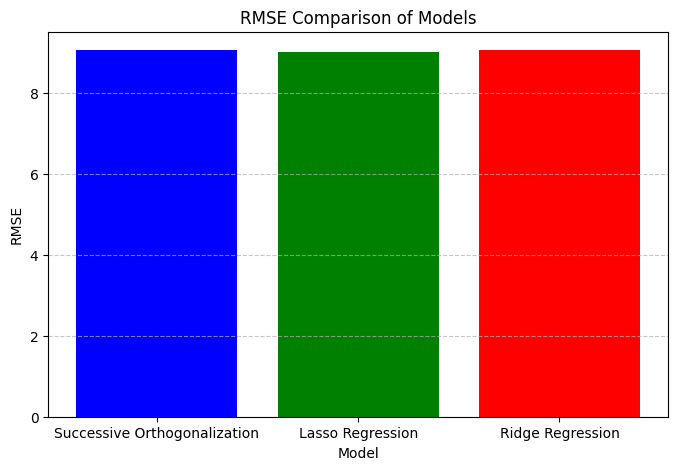

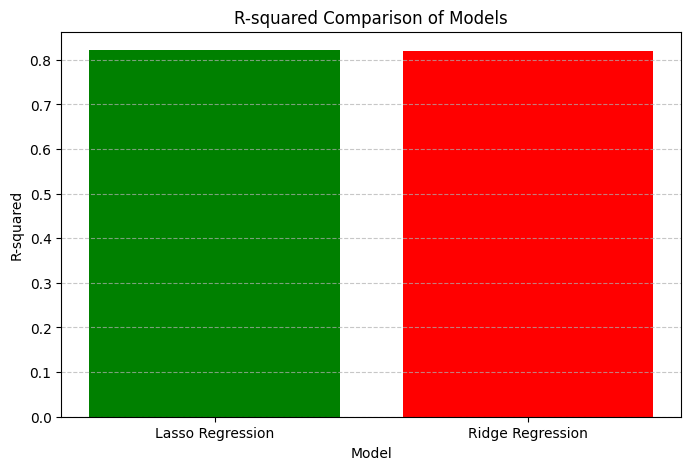

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge
from sklearn.model_selection import KFold
from math import sqrt

# Load the uploaded CSV files
train_file_path = "deliverytimeprediction_train.csv"
test_file_path = "deliverytimeprediction_test.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Prepare features and target variable
X_train = train_df.drop(columns=["Delivery_Time_min"])
y_train = train_df["Delivery_Time_min"]
X_test = test_df.drop(columns=["Delivery_Time_min"])
y_test = test_df["Delivery_Time_min"]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Successive Orthogonalization
n_features = X_train_scaled.shape[1]
feature_names = X_train.columns
residuals_train = y_train.copy()
residuals_test = y_test.copy()

Z_train = np.zeros_like(X_train_scaled)
Z_test = np.zeros_like(X_test_scaled)
coefficients_history = []
rmses_orthogonal = []

for i in range(n_features):
    feature_name = feature_names[i]
    x_i_train = X_train_scaled[:, i].copy()
    x_i_test = X_test_scaled[:, i].copy()

    for j in range(i):
        x_j_train = Z_train[:, j]
        x_j_test = Z_test[:, j]
        proj_coeff = np.dot(x_i_train, x_j_train) / np.dot(x_j_train, x_j_train)
        x_i_train -= proj_coeff * x_j_train
        x_i_test -= proj_coeff * x_j_test

    Z_train[:, i] = x_i_train
    Z_test[:, i] = x_i_test

    regressor = LinearRegression().fit(x_i_train.reshape(-1, 1), residuals_train)
    coefficient = regressor.coef_[0]
    residuals_train -= regressor.predict(x_i_train.reshape(-1, 1))
    residuals_test -= regressor.predict(x_i_test.reshape(-1, 1))

    rmse = sqrt(mean_squared_error(y_test, y_test - residuals_test))

    coefficients_history.append({"Step": i + 1, "Feature": feature_name, "Coefficient": coefficient})
    rmses_orthogonal.append(rmse)

rmse_orthogonal = rmses_orthogonal[-1]

# Lasso Regression
lasso_cv = LassoCV(cv=KFold(n_splits=5, shuffle=True, random_state=42), random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha_lasso = lasso_cv.alpha_
lasso_best = Lasso(alpha=best_alpha_lasso, random_state=42)
lasso_best.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_best.predict(X_test_scaled)
rmse_lasso = sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Ridge Regression
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=KFold(n_splits=5, shuffle=True, random_state=42))
ridge_cv.fit(X_train_scaled, y_train)
best_alpha_ridge = ridge_cv.alpha_
ridge_best = Ridge(alpha=best_alpha_ridge, random_state=42)
ridge_best.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_best.predict(X_test_scaled)
rmse_ridge = sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Model Comparison
model_comparison_df = pd.DataFrame({
    "Model": ["Successive Orthogonalization", "Lasso Regression", "Ridge Regression"],
    "RMSE": [rmse_orthogonal, rmse_lasso, rmse_ridge],
    "R-squared": ["N/A", r2_lasso, r2_ridge]  # R-squared for orthogonalization is not straightforward to compute
})

# Print Model Comparison Results
print("Model Comparison Results")
print(model_comparison_df)

# Plot RMSE Comparison
plt.figure(figsize=(8, 5))
plt.bar(model_comparison_df["Model"], model_comparison_df["RMSE"], color=['blue', 'green', 'red'])
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Comparison of Models")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

# Plot R-squared Comparison (excluding orthogonalization since it's N/A)
plt.figure(figsize=(8, 5))
plt.bar(["Lasso Regression", "Ridge Regression"], model_comparison_df["R-squared"][1:], color=['green', 'red'])
plt.xlabel("Model")
plt.ylabel("R-squared")
plt.title("R-squared Comparison of Models")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()


**Model Comparison:**

\Based on the results, Lasso Regression performed the best in terms of predictive accuracy, as it had the lowest RMSE (9.022) and the highest R-squared (0.822). Here's an analysis of the models:

